# Logistic Regression Tutorial Pt. 2
<br>
In the second half of the assignment, we will be working with Logistic Regression on another dataset which deals with microchip testing. We are given training data with two features, "Microchip test 1" and "Microchip test 2", and a label column "Accepted" deeming if the chip was accepted based on the two tests. Let's start off with visualizing our data.

     Microchip Test 1  Microchip Test 2  Accepted
0    0.051267          0.699560          1       
1   -0.092742          0.684940          1       
2   -0.213710          0.692250          1       
3   -0.375000          0.502190          1       
4   -0.513250          0.465640          1       
..        ...               ...         ..       
113 -0.720620          0.538740          0       
114 -0.593890          0.494880          0       
115 -0.484450          0.999270          0       
116 -0.006336          0.999270          0       
117  0.632650         -0.030612          0       

[118 rows x 3 columns]


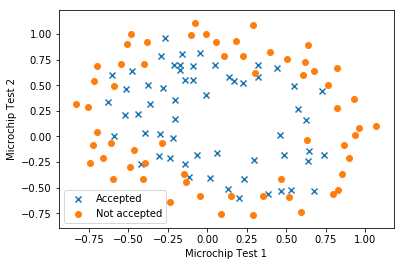

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

pd.set_option('display.max_columns', None)  
pd.options.display.max_rows = 10

df = pd.read_csv('ex2data2.txt', names=["Microchip Test 1", "Microchip Test 2", "Accepted"])
print(df)

accepted = df[df["Accepted"] == 1]
notAccepted = df[df["Accepted"] == 0]

acceptedTest1 = accepted["Microchip Test 1"] # x axis
acceptedTest2 = accepted["Microchip Test 2"] # y axis

notAcceptedTest1 = notAccepted["Microchip Test 1"] # x axis
notAcceptedTest2 = notAccepted["Microchip Test 2"] # y axis

plt.scatter(acceptedTest1, acceptedTest2, marker='x', label="Accepted")
plt.scatter(notAcceptedTest1, notAcceptedTest2, marker='o', label="Not accepted")
plt.legend()
plt.xlabel("Microchip Test 1")
plt.ylabel("Microchip Test 2")
plt.show()

Notice how this dataset's decision boundary cannot be simply represented by a line. We will need to map a more complex polynomial equation to accurately determine this dataset's decision boundary. Thus, we will map the features ($x_1, x_2$) to be polynomial terms up to the sixth-power so that we can come up with this more complex decison boundary:

$$ \begin{equation}
     mapFeatures(x) = mapFeatures(x_1,x_2) =\begin{bmatrix}
         1 \\
         x_1 \\
         x_2 \\
         x_1^2 \\
         x_1x_2 \\
         x_2^2 \\
         ... \\
         x_1x_2^5 \\
         x_2^6
        \end{bmatrix}
  \end{equation} $$
  
This means that for every feature row in the DataFrame, we will transform that row so that it reflects the new polynomial terms described above. That is, we will compute $1, x_1, x_2, x_1^2, x_1x_2, ... , x_1x_2^5, x_2^6$ and that will be a row for our transformed X data. In total there should be still 118 rows but the number of columns increase to 28 since we are adding the new computed terms. We will leverage *sci-kit learn*'s tools to easily come up with our transformed X matrix.

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=6) 

X_data = df[df.columns[:-1]]
y_data = df[df.columns[-1]]

pd.set_option('display.max_columns', 10)  
transformedX_data = poly.fit_transform(X_data)

print(pd.DataFrame(transformedX_data))

       0         1         2         3         4      ...                 23  \
0    1.0  0.051267  0.699560  0.002628  0.035864      ...       3.380660e-06   
1    1.0 -0.092742  0.684940  0.008601 -0.063523      ...       3.470651e-05   
2    1.0 -0.213710  0.692250  0.045672 -0.147941      ...       9.995978e-04   
3    1.0 -0.375000  0.502190  0.140625 -0.188321      ...       4.987251e-03   
4    1.0 -0.513250  0.465640  0.263426 -0.238990      ...       1.504584e-02   
..   ...       ...       ...       ...       ...      ...                ...   
113  1.0 -0.720620  0.538740  0.519293 -0.388227      ...       7.826790e-02   
114  1.0 -0.593890  0.494880  0.352705 -0.293904      ...       3.046659e-02   
115  1.0 -0.484450  0.999270  0.234692 -0.484096      ...       5.499985e-02   
116  1.0 -0.006336  0.999270  0.000040 -0.006332      ...       1.609667e-09   
117  1.0  0.632650 -0.030612  0.400246 -0.019367      ...       1.501196e-04   

               24            25        

matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can check if our transformedX_data matrix makes sense. 
<br>
The 1st column = 1, the 2nd column = $x_1$, the 3rd column = $x_2$, the 4th column = $x_1^2$, the 5th column = $x_1x_2$, ... , the 28th column = $x_2^6$. 
<br><br>
If we take the first row for example, ($x_1 = 0.051267, x_2 = 0.699560$) we can quickly check that: <br><br>
$$x_1x_2 = 0.051267 \times 0.699560 = 0.03586~ ~\text{(5th column)} \\  
x_2^6 = 0.669560^6 = 1.172060e-01 ~ ~\text{(28th column)}$$

Now that we have our transformed matrix, we can now move forward with the logistic regression algorithm and fit our theta parameters that will minimize our objective cost function by once again using the gradient and advanced optimization techniques. However this time, the assignment asks for us to incorporate **regularization** into our cost function and gradient calculation. First, let's introduce the concept of **overfitting/underfitting**. 

![](https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/overfitting-logreg-ex.png)

**Overfitting** occurs when the determined model is complex to the point that it fits the training data too well. So although the model fits the training data extrememly well, the model will likely not perform well for new test data since the model caters to the training data too well. **Underfitting** is the opposite, which happens when the model is too simple and cannot fit the data well. In machine learning, we strive to find the balance between overfitting and underfitting data, but in practice this is very hard to do.

One way to reduce overfitting is to incorporate **regularization**. Say we want to make the following expression more linear: $$ \theta_0 + \theta_1x + \theta_2x^2 + \theta_3x^3 + \theta_4x^4$$

Thus we want to reduce the influence of the $\theta_2x^2, \theta_3x^3, \theta_4x^4$ terms. We do this by modifying our cost function (for linear regression) like so:

$$
cost = \frac{1}{2m} \sum_{i = 1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 + 5000\theta_2^2 + 5000\theta_3^3 + 5000\theta_4^4
$$

Since we want to find theta values that will minimize the cost function, $\theta_2, \theta_3, \theta_4$ are going to be very small values since they have been heavily "inflated" by a factor of 5000. Thus we have regularized the equation by reducing the complexity of the expression (by reducing the influence of $\theta_2$) and thus reduced overfitting!

The regularized cost function for logistic regression is generalized using all the $\theta$ terms **except $\theta_0$** through the following equation:

$$
cost = \frac{1}{m} \sum_{i = 1}^m -y^{(i)}\log{}h_\theta(x^{(i)}) - (1-y^{(i)})(1-\log{}h_\theta(x^{(i)})) + \frac{\lambda}{2m}\sum_{j = 1}^m \theta_j^2
$$

Note that $\lambda$ is called the **regularization parameter** and it determines how much to inflate our $\theta$ parameters. Thus, higher $\lambda$ values will reduce overfitting by a bigger measure (perhaps to the point that it will underfit) whereas low $\lambda$ or $\lambda = 0$ means no regularization which entails the possibility of overfitting. Okay time to implement the regularizedCost function for logistic regression!

In [28]:
def sigmoid(x): # same as before
    return 1.0/(1+ math.exp(-x))

def sigmoidMatrix(matrix): # same as before
    for x in np.nditer(matrix, op_flags=['readwrite']):
        x[...]=sigmoid(x)
    return matrix

def regularizedCost(theta,X,y,lamda):
    theta_with_0_as_first = np.insert(theta[1:], 0, 0) 
    # important! don't want to incorporate theta_0 for the regularization term
    # thus substitute theta_0 with 0 and use this variable for our reg term
    
    theta = np.matrix(theta)
    m = len(y)
    h = sigmoidMatrix(X*theta.T)
    
    reg_term = lamda*np.sum(theta_with_0_as_first) / (2*m)
    
    cost = (-y.T * np.log(h) - (1-y).T * np.log(1-h))/m + reg_term
    return cost[0,0]

In [29]:
theta = np.zeros(transformedX_data.shape[1])
lamda = 1
y_data = np.asmatrix(y_data).T

print(regularizedCost(theta,transformedX_data, y_data, lamda))

0.69314718056


In [30]:
def gradient(theta, X,y,lamda):
    theta_with_0_as_first = np.insert(theta[1:],0,0)
    theta = np.matrix(theta)
    theta_with_0_as_first = np.matrix(theta_with_0_as_first)
    m = len(y)
    error = sigmoidMatrix(X*theta.T) - y
    gradient = (X.T * error) / m + (lamda/m) * theta_with_0_as_first.T
    return gradient

print(gradient(theta,transformedX_data, y_data, lamda))

[[  8.47457627e-03]
 [  1.87880932e-02]
 [  7.77711864e-05]
 [  5.03446395e-02]
 [  1.15013308e-02]
 [  3.76648474e-02]
 [  1.83559872e-02]
 [  7.32393391e-03]
 [  8.19244468e-03]
 [  2.34764889e-02]
 [  3.93486234e-02]
 [  2.23923907e-03]
 [  1.28600503e-02]
 [  3.09593720e-03]
 [  3.93028171e-02]
 [  1.99707467e-02]
 [  4.32983232e-03]
 [  3.38643902e-03]
 [  5.83822078e-03]
 [  4.47629067e-03]
 [  3.10079849e-02]
 [  3.10312442e-02]
 [  1.09740238e-03]
 [  6.31570797e-03]
 [  4.08503006e-04]
 [  7.26504316e-03]
 [  1.37646175e-03]
 [  3.87936363e-02]]


In [92]:
lamda = 10
theta = np.ones(transformedX_data.shape[1])

print(regularizedCost(theta,transformedX_data,y_data,lamda))

print(gradient(theta,transformedX_data, y_data,lamda))

# lamda = 1
# theta = np.ones(transformedX_data.shape[1])

from scipy.optimize import fmin_tnc
minimum = fmin_tnc(func=regularizedCost, x0=theta, fprime=gradient, args=(transformedX_data, y_data, lamda))
cost = regularizedCost(minimum[0],transformedX_data,y_data,lamda)
new_theta = np.matrix(minimum[0])
print (cost)
print (new_theta)

3.16450933162
[[ 0.34604507]
 [ 0.16135192]
 [ 0.19479576]
 [ 0.22686278]
 [ 0.09218568]
 [ 0.24438558]
 [ 0.14339212]
 [ 0.10844171]
 [ 0.10231439]
 [ 0.18346846]
 [ 0.17353003]
 [ 0.08725552]
 [ 0.11822776]
 [ 0.0858433 ]
 [ 0.19994895]
 [ 0.13522653]
 [ 0.09497527]
 [ 0.09356441]
 [ 0.09979784]
 [ 0.09140157]
 [ 0.17485242]
 [ 0.14955442]
 [ 0.08678566]
 [ 0.09897686]
 [ 0.08531951]
 [ 0.10190666]
 [ 0.08450198]
 [ 0.18228323]]
0.494537069667
[[ 0.32617845 -0.00816167  0.16577566 -0.4467107  -0.11177062 -0.27891206
  -0.07146233 -0.0578822  -0.06509221 -0.10636616 -0.33673632 -0.01297725
  -0.11670702 -0.02811068 -0.28602736 -0.11614874 -0.03704565 -0.02242813
  -0.04885919 -0.04163398 -0.18675511 -0.25334225 -0.00291228 -0.0579624
  -0.00053023 -0.0635291  -0.01206538 -0.27148738]]


In [38]:
y_data

matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [66]:
theta = np.arange(transformedX_data.shape[1])
print(theta)
theta = np.matrix(theta)
print(theta)
theta[0][0]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]]


matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]])